In [1]:
#STDLIB
from typing import NamedTuple
import sys
sys.path.append("../../")
import pickle
import importlib

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'vibrant'])

import numpy as np
from tqdm import tqdm

kernel_module = importlib.import_module('kooplearn.kernels')
from simulate import SimulationData
from eigenvalues_error_bounds import eigenvalue_errors, eps_n_1, error_decay_variable
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
with open("data/spurious_RBF.pkl", 'rb') as f:
    data = pickle.load(f)

Text(0.5, 0, '\\# of independent simulation')

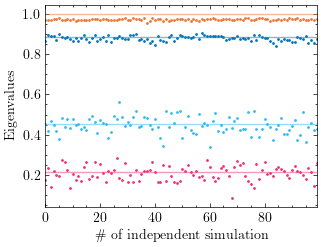

In [4]:
fig, ax = plt.subplots()
for i in range(data.eigenvalues.shape[1]):
    ax.plot(data.eigenvalues[:, i],'.', c=colors[i], ms=2)
    ax.axhline(data.benchmark[i], c=colors[i], alpha=0.5)
ax.margins(x=0)
ax.set_ylabel("Eigenvalues")
ax.set_xlabel("\# of independent simulation")

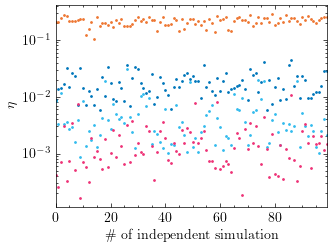

In [5]:
fig, ax = plt.subplots()
for i in range(data.eigenvalues.shape[1]):
    ax.plot(data.eta[:, i].real,'.', c=colors[i], ms=2)
ax.margins(x=0)
ax.set_ylabel("$\eta$")
ax.set_xlabel("\# of independent simulation")
ax.set_yscale('log')

### Eigenvalues error bounds

In [19]:
configs = data.configs_dump
kernel_class = getattr(kernel_module, configs["kernel"])
confidence_interval = 0.95
errors = np.zeros_like(data.eigenvalues, dtype=np.float64)
kernel = kernel_class(**configs["kernel_kwargs"])
tikhonov_reg = configs["estimator_kwargs"]["tikhonov_reg"]
for ds_index in tqdm(range(data.eigenvalues.shape[0]), desc='Evaluating empirical eigenvalue errors'):
    eta = data.eta[ds_index]
    sval_B_rp1 = data.sval_B_rp1[ds_index]
    X = data.datasets[0][ds_index]
    errors[ds_index] = eigenvalue_errors(eta, sval_B_rp1, X, kernel, 1 - confidence_interval, tikhonov_reg)

Evaluating empirical eigenvalue errors:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2733652/3995258950.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  errors[ds_index] = eigenvalue_errors(eta, sval_B_rp1, X, kernel, 1 - confidence_interval, tikhonov_reg)
Evaluating empirical eigenvalue errors: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


### RRR vs. PCR estimation

In [16]:
with open("data/RRR_RBF.pkl", 'rb') as f:
    data_RRR = pickle.load(f)
with open("data/PCR_RBF.pkl", 'rb') as f:
    data_PCR = pickle.load(f)

In [24]:
class Stats(NamedTuple):
    mean: np.ndarray
    std: np.ndarray
def statistics(eigenvalues: np.ndarray) -> Stats:
    eigenvalues = np.flip(np.sort(eigenvalues, axis=1), axis=1)
    mean = np.mean(eigenvalues, axis=0)
    std = np.std(eigenvalues, axis=0)
    return Stats(mean, std)

Text(0.5, 1.0, 'Eigenvalue estimation error: RRR vs PCR')

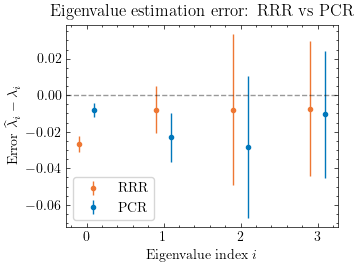

In [53]:
dx = 0.1
x = np.arange(4)

PCR_s = statistics(data_PCR.eigenvalues)
RRR_s = statistics(data_RRR.eigenvalues)

fig, ax = plt.subplots()
ax.errorbar(x - dx, RRR_s.mean - data_PCR.benchmark, yerr=RRR_s.std, fmt='.', c=colors[0], label="RRR")
ax.errorbar(x + dx, PCR_s.mean- data_PCR.benchmark, yerr=PCR_s.std, fmt='.', c=colors[1], label="PCR")

ax.axhline(0, ls="--", c='k', alpha=0.4)
ax.legend(frameon=True, loc='lower left')

ax.set_xlabel("Eigenvalue index $i$")
ax.set_ylabel("Error $\widehat{\lambda}_{i} - \lambda_{i}$")

ax.set_title("Eigenvalue estimation error: RRR vs PCR")